In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

ModuleNotFoundError: No module named 'fastai'

In [ ]:
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import scipy.io
from PIL import Image

plt.ion()   # interactive mode

In [ ]:
!nvidia-smi

In [ ]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
torch.cuda.is_available()

In [ ]:
PATH = Path('../../../../../data/StanfordCars')

In [ ]:
import os
print(os.listdir(PATH))

In [ ]:
PATH.ls()

In [ ]:
path_train = PATH/'cars_train'
path_test = PATH/'cars_test'

In [ ]:
fnames = get_image_files(path_train)
fnames[:5]

In [ ]:
print(f'Total number of images: {len(fnames)}')

In [ ]:
pic = Path(f'{path_train}/00001.jpg')
img = plt.imread(pic)
plt.imshow(img);

In [ ]:
print(os.listdir(f'{PATH}/devkit'))

In [ ]:
#load cars class labels matlab file
class_annos = scipy.io.loadmat(PATH/'devkit/cars_meta.mat')

In [ ]:
class_annos

In [ ]:
class_annos["class_names"][0][14][0]

In [ ]:
#load train annotiation file
train_annos = scipy.io.loadmat(PATH/'devkit/cars_train_annos.mat')

In [ ]:
# matlab file decoding mask inside 'annotations' array
# dtype=[('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('fname', 'O')])}
train_annos

In [ ]:
# extract item 0 class
train_annos["annotations"][0][0][4][0][0]

In [ ]:
# extract itme 0 file name
train_annos["annotations"][0][0][5][0]

In [ ]:
total_set = len(train_annos["annotations"][0])
print(f'Total number of data items in dataset: {total_set}')

In [ ]:
classes_total = len(class_annos["class_names"][0])
print(f'Total number of classes: {classes_total}')

In [ ]:
# loop to extract file name and class number into list
#                                                     fname                                    class
classes = [[f'cars_train/{train_annos["annotations"][0][i][5][0]}',train_annos["annotations"][0][i][4][0][0]] for i in range(total_set)]
classes[:5]

In [ ]:
# Create the pandas DataFrame from list
df = pd.DataFrame(classes, columns = ['name', 'label']) 
df.head()

In [ ]:
# transform class number from [1..196] to [0..195]
df['label'] = df['label']-1
df['label'].min(), df['label'].max()

In [ ]:
df.head()

In [ ]:
# verify number of unique classes
len(df['label'].unique())

In [ ]:
# verify length of car class annotations in cars_meta.mat
total_labels = len(class_annos["class_names"][0])
total_labels

In [ ]:
class_annos

In [ ]:
# extract class label strings into list
labels = [class_annos["class_names"][0][i][0] for i in range(total_labels)]
labels[:5], len(labels)

In [ ]:
# creating datafreame form list
df_label = pd.DataFrame(labels)
print(f' dataframe shape: {df_label.shape}')
df_label.head()

In [ ]:
# create data frame new_labels of class labels sorted according to class numbers
new_labels = pd.DataFrame(df_label[0][df['label']])

In [ ]:
new_labels.head()

In [ ]:
# reset index
new_labels.reset_index(inplace=True)
new_labels=new_labels.drop(columns='index', axis=1)
new_labels.head()

In [ ]:
# reaplace integer class numbers with string  class labels
df['label'] = new_labels
df.head()

In [39]:
# create python data dictionary {}, path/file and image size(x,y)
# ps very long processing time
e_d = {k: PIL.Image.open(k).size for k in fnames}
#transform to list
row_sz, col_sz = list(zip(*e_d.values()))
# and to numpy
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
row_sz.shape, col_sz.shape

((8144,), (8144,))

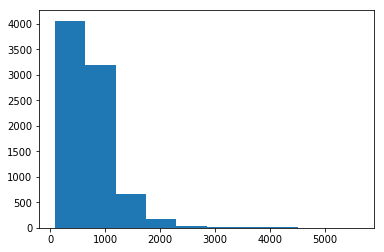

In [40]:
plt.hist(row_sz);

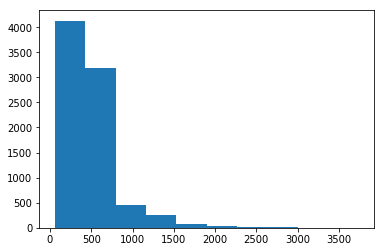

In [41]:
plt.hist(col_sz);

In [42]:
# histogram of all classes
# TODO

In [43]:
# check for NoN values
df['label'].isnull().any()

False

In [44]:
# split dataframe into train and test
import random
np.random.seed(42)

def splitDF(df, train_ratio):
    df['random_number'] = np.random.rand(len(df))

    train = df[df['random_number'] <= train_ratio]
    test = df[df['random_number'] > train_ratio]
    return (train, test)

In [45]:
train, test = splitDF(df,0.8)

In [46]:
len(train), len(test)

(6526, 1618)

In [47]:
train.head(10)

,name,label,random_number
0,cars_train/00001.jpg,Audi TTS Coupe 2012,0.374540
2,cars_train/00003.jpg,Dodge Dakota Club Cab 2007,0.731994
3,cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012,0.598658
4,cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012,0.156019
5,cars_train/00006.jpg,Geo Metro Convertible 1993,0.155995
6,cars_train/00007.jpg,Dodge Journey SUV 2012,0.058084
8,cars_train/00009.jpg,Mitsubishi Lancer Sedan 2012,0.601115
9,cars_train/00010.jpg,Chevrolet Traverse SUV 2012,0.708073
10,cars_train/00011.jpg,Buick Verano Sedan 2012,0.020584
13,cars_train/00014.jpg,Dodge Caravan Minivan 1997,0.212339


In [48]:
test.head()

,name,label,random_number
1,cars_train/00002.jpg,Acura TL Sedan 2012,0.950714
7,cars_train/00008.jpg,Dodge Charger Sedan 2012,0.866176
11,cars_train/00012.jpg,Toyota Sequoia SUV 2012,0.969910
12,cars_train/00013.jpg,Hyundai Elantra Sedan 2007,0.832443
33,cars_train/00034.jpg,Hyundai Veracruz SUV 2012,0.948886


In [49]:
Data_DIR = '/home/norvilr/ml/data/StanfordCars'
Model_DIR = '/home/norvilr/ml/github/AI/VSoAI/ImageClassification/StanfordCars2'

#create folders based on class labels and copy files
#run just once, to create folders and copy files

os.getcwd() 

def createClassFolders():
    for folder in df['label']:
        if not os.path.exists(folder):
            os.makedirs(folder)   

if os.getcwd()  != Data_DIR:
    os.chdir(Data_DIR)
!ls

if not os.path.exists('train'):
    os.makedirs('train')    
if not os.path.exists('test'):
    os.makedirs('test')
print(os.listdir())    

if os.path.exists('train'):
    os.chdir('train')
    createClassFolders()
if os.path.exists('../test'):
    os.chdir('../test')
    createClassFolders()    
os.chdir('../')    

print( 'created class subdirectories in train: ')
!find train -mindepth 1 -type d | wc -l
print( 'created class subdirectories in train: ')
!find test -mindepth 1 -type d | wc -l

#copy files into train subdirs
for index, row in train.iterrows():
    cmd = f'cp -f {row["name"]} train/"{row["label"]}"/'
    os.popen(cmd) 

#copy files into test subdirs
for index, row in test.iterrows():
    cmd = f'cp -f {row["name"]} test/"{row["label"]}"/'
    os.popen(cmd) 

#return to jupyter notebook directory
if os.getcwd()  != Model_DIR:
    os.chdir(Model_DIR)
!ls

In [50]:
train_dir = 'train'
val_dir = 'test'

batch_size = 16

In [51]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    train_dir: transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.Resize(224),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_dir: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [52]:
classes = os.listdir(f'{Data_DIR}/train')
classes.sort()
ClassesNumer = len(classes)
print("Class Total Count: ", ClassesNumer)

Class Total Count:  196


In [53]:

image_datasets = {x: datasets.ImageFolder(os.path.join(Data_DIR, x), transform=data_transforms[x]) for x in [train_dir, val_dir]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in [train_dir, val_dir]}

dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}

class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [54]:
image_datasets[train_dir]

Dataset ImageFolder
    Number of datapoints: 6571
    Root location: /home/norvilr/ml/data/StanfordCars/train

In [55]:
# Iterate through the dataloader once
trainiter = iter(dataloaders[train_dir])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_dir, val_dir]:
            if phase == train_dir:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_dir):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_dir:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == val_dir and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [57]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.resnet152(pretrained=True)
#model_ft = models.resnet34(pretrained=True)

#adding one fully connected layer with output=Classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, ClassesNumer)
model_ft = model_ft.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
#optimizer_ft = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.01, max_lr=0.1)


In [58]:
# freeze all layers except last ones added next
for param in model_ft.parameters():
    param.requires_grad = False    
# Then unfreeze last classification layer only for feature extract
for param in model_ft.fc.parameters():
    param.requires_grad = True  
#To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)   

weight False
weight False
bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
1.conv3.weight False
1.bn3.weight False
1.bn3.bias False
2.conv1.weight False
2.bn1.weight False
2.bn1.bias False
2.conv2.weight False
2.bn2.weight False
2.bn2.bias False
2.conv3.weight False
2.bn3.weight False
2.bn3.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
1

In [59]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 5.2269 Acc: 0.0286
test Loss: 4.5949 Acc: 0.1024

Epoch 1/4
----------
train Loss: 4.4887 Acc: 0.0966
test Loss: 4.0378 Acc: 0.1418

Epoch 2/4
----------
train Loss: 4.0332 Acc: 0.1572
test Loss: 3.7704 Acc: 0.1742

Epoch 3/4
----------
train Loss: 3.8179 Acc: 0.1878
test Loss: 3.4828 Acc: 0.2136

Epoch 4/4
----------
train Loss: 3.5829 Acc: 0.2261
test Loss: 3.4425 Acc: 0.2098

Training complete in 2m 52s
Best val Acc: 0.213605


In [60]:
#UnFreeze all layers first
for param in model_ft.parameters():
    param.requires_grad = True 

# To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

weight True
weight True
bias True
0.conv1.weight True
0.bn1.weight True
0.bn1.bias True
0.conv2.weight True
0.bn2.weight True
0.bn2.bias True
0.conv3.weight True
0.bn3.weight True
0.bn3.bias True
0.downsample.0.weight True
0.downsample.1.weight True
0.downsample.1.bias True
1.conv1.weight True
1.bn1.weight True
1.bn1.bias True
1.conv2.weight True
1.bn2.weight True
1.bn2.bias True
1.conv3.weight True
1.bn3.weight True
1.bn3.bias True
2.conv1.weight True
2.bn1.weight True
2.bn1.bias True
2.conv2.weight True
2.bn2.weight True
2.bn2.bias True
2.conv3.weight True
2.bn3.weight True
2.bn3.bias True
0.conv1.weight True
0.bn1.weight True
0.bn1.bias True
0.conv2.weight True
0.bn2.weight True
0.bn2.bias True
0.conv3.weight True
0.bn3.weight True
0.bn3.bias True
0.downsample.0.weight True
0.downsample.1.weight True
0.downsample.1.bias True
1.conv1.weight True
1.bn1.weight True
1.bn1.bias True
1.conv2.weight True
1.bn2.weight True
1.bn2.bias True
1.conv3.weight True
1.bn3.weight True
1.bn3.bias Tru

In [61]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.01, max_lr=1)

In [62]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------
train Loss: 3.2714 Acc: 0.2468
test Loss: 2.9160 Acc: 0.3020

Epoch 1/20
----------
train Loss: 2.4691 Acc: 0.3818
test Loss: 1.8331 Acc: 0.5079

Epoch 2/20
----------
train Loss: 2.0584 Acc: 0.4722
test Loss: 2.2528 Acc: 0.4234

Epoch 3/20
----------
train Loss: 1.8497 Acc: 0.5188
test Loss: 1.6768 Acc: 0.5334

Epoch 4/20
----------
train Loss: 1.6525 Acc: 0.5635
test Loss: 1.5862 Acc: 0.5779

Epoch 5/20
----------
train Loss: 1.5611 Acc: 0.5921
test Loss: 1.8952 Acc: 0.5391

Epoch 6/20
----------
train Loss: 1.4590 Acc: 0.6198
test Loss: 1.3742 Acc: 0.6427

Epoch 7/20
----------
train Loss: 1.3814 Acc: 0.6284
test Loss: 1.4366 Acc: 0.6065

Epoch 8/20
----------
train Loss: 1.3246 Acc: 0.6517
test Loss: 1.6666 Acc: 0.5931

Epoch 9/20
----------
train Loss: 1.2930 Acc: 0.6593
test Loss: 1.3981 Acc: 0.6281

Epoch 10/20
----------
train Loss: 1.1892 Acc: 0.6883
test Loss: 1.4161 Acc: 0.6351

Epoch 11/20
----------
train Loss: 1.1978 Acc: 0.6786
test Loss: 1.2095 Acc

In [63]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.001, max_lr=0.1)
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------
train Loss: 0.6335 Acc: 0.8364
test Loss: 0.5364 Acc: 0.8525

Epoch 1/20
----------
train Loss: 0.4986 Acc: 0.8688
test Loss: 0.4868 Acc: 0.8557

Epoch 2/20
----------
train Loss: 0.4592 Acc: 0.8851
test Loss: 0.4629 Acc: 0.8665

Epoch 3/20
----------
train Loss: 0.4480 Acc: 0.8853
test Loss: 0.4461 Acc: 0.8678

Epoch 4/20
----------
train Loss: 0.4098 Acc: 0.8936
test Loss: 0.4340 Acc: 0.8767

Epoch 5/20
----------
train Loss: 0.3995 Acc: 0.8974
test Loss: 0.4326 Acc: 0.8767

Epoch 6/20
----------
train Loss: 0.4041 Acc: 0.8974
test Loss: 0.4158 Acc: 0.8792

Epoch 7/20
----------
train Loss: 0.3881 Acc: 0.9031
test Loss: 0.4207 Acc: 0.8773

Epoch 8/20
----------
train Loss: 0.3766 Acc: 0.9018
test Loss: 0.4115 Acc: 0.8837

Epoch 9/20
----------
train Loss: 0.3631 Acc: 0.9081
test Loss: 0.4240 Acc: 0.8792

Epoch 10/20
----------
train Loss: 0.3415 Acc: 0.9095
test Loss: 0.4193 Acc: 0.8760

Epoch 11/20
----------
train Loss: 0.3392 Acc: 0.9126
test Loss: 0.4114 Acc

In [64]:
# Sequential(
#   (0): AdaptiveAvgPool2d(output_size=1)
#   (1): AdaptiveMaxPool2d(output_size=1)
#   (2): Flatten()
#   (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (4): Dropout(p=0.25)
#   (5): Linear(in_features=1024, out_features=512, bias=True)
#   (6): ReLU(inplace)
#   (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (8): Dropout(p=0.5)
#   (9): Linear(in_features=512, out_features=10, bias=True)

In [65]:
# Resize images from 224 to 299
data_transforms = {
    train_dir: transforms.Compose([
        transforms.RandomResizedCrop(299),
        #transforms.RandomRotation(degrees=15),
        #transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_dir: transforms.Compose([
        transforms.Resize(312),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [66]:
image_datasets = {x: datasets.ImageFolder(os.path.join(Data_DIR, x), transform=data_transforms[x]) for x in [train_dir, val_dir]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in [train_dir, val_dir]}


In [67]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.001, max_lr=0.1)
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=21)

Epoch 0/20
----------
train Loss: 0.5270 Acc: 0.8752
test Loss: 0.3474 Acc: 0.8951

Epoch 1/20
----------
train Loss: 0.4855 Acc: 0.8872
test Loss: 0.3372 Acc: 0.8938

Epoch 2/20
----------
train Loss: 0.4532 Acc: 0.8853
test Loss: 0.3542 Acc: 0.8900

Epoch 3/20
----------
train Loss: 0.4331 Acc: 0.8956
test Loss: 0.3523 Acc: 0.8926

Epoch 4/20
----------
train Loss: 0.4273 Acc: 0.8948
test Loss: 0.3848 Acc: 0.8907

Epoch 5/20
----------
train Loss: 0.4288 Acc: 0.8945
test Loss: 0.3959 Acc: 0.8887

Epoch 6/20
----------
train Loss: 0.4032 Acc: 0.9023
test Loss: 0.3840 Acc: 0.8818

Epoch 7/20
----------
train Loss: 0.3953 Acc: 0.9025
test Loss: 0.3877 Acc: 0.8957

Epoch 8/20
----------
train Loss: 0.3930 Acc: 0.8989
test Loss: 0.3721 Acc: 0.8824

Epoch 9/20
----------
train Loss: 0.3777 Acc: 0.9046
test Loss: 0.4183 Acc: 0.8805

Epoch 10/20
----------
train Loss: 0.3822 Acc: 0.9012
test Loss: 0.4009 Acc: 0.8856

Epoch 11/20
----------
train Loss: 0.3907 Acc: 0.9018
test Loss: 0.3712 Acc

KeyboardInterrupt: 

In [68]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.0001, max_lr=0.01)
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.3317 Acc: 0.9175
test Loss: 0.3779 Acc: 0.8913

Epoch 1/15
----------
train Loss: 0.3245 Acc: 0.9224
test Loss: 0.3610 Acc: 0.8938

Epoch 2/15
----------
train Loss: 0.3230 Acc: 0.9206
test Loss: 0.3548 Acc: 0.9027

Epoch 3/15
----------
train Loss: 0.3009 Acc: 0.9280
test Loss: 0.3552 Acc: 0.8983

Epoch 4/15
----------
train Loss: 0.2756 Acc: 0.9323
test Loss: 0.3519 Acc: 0.9027

Epoch 5/15
----------
train Loss: 0.3028 Acc: 0.9256
test Loss: 0.3465 Acc: 0.9021

Epoch 6/15
----------
train Loss: 0.2907 Acc: 0.9291
test Loss: 0.3642 Acc: 0.8983

Epoch 7/15
----------
train Loss: 0.2743 Acc: 0.9333
test Loss: 0.3475 Acc: 0.9034

Epoch 8/15
----------
train Loss: 0.2772 Acc: 0.9356
test Loss: 0.3645 Acc: 0.8926

Epoch 9/15
----------
train Loss: 0.2646 Acc: 0.9361
test Loss: 0.3701 Acc: 0.8957

Epoch 10/15
----------
train Loss: 0.2792 Acc: 0.9327
test Loss: 0.3595 Acc: 0.8983

Epoch 11/15
----------
train Loss: 0.2514 Acc: 0.9402
test Loss: 0.3668 Acc

In [69]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.00001, max_lr=0.001)
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3010 Acc: 0.9298
test Loss: 0.3678 Acc: 0.8989

Epoch 1/4
----------
train Loss: 0.2677 Acc: 0.9350
test Loss: 0.3638 Acc: 0.8957

Epoch 2/4
----------
train Loss: 0.2885 Acc: 0.9329
test Loss: 0.3601 Acc: 0.8951

Epoch 3/4
----------
train Loss: 0.2803 Acc: 0.9336
test Loss: 0.3646 Acc: 0.8970

Epoch 4/4
----------
train Loss: 0.2617 Acc: 0.9379
test Loss: 0.3643 Acc: 0.8970

Training complete in 15m 11s
Best val Acc: 0.898919
